In [ ]:
!pip install --upgrade keras-tuner

In [95]:
import math
import gc
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import utils
from scipy import stats
from tensorflow.keras import layers
import keras_tuner as kt

# Data preparation

## Exploration

In [7]:
data = pd.read_csv('/content/data.txt', sep='\t', lineterminator='\r', header=None)

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,>,0,0,0,0,1,0,0,0,0,NaN
1,0.25,0.25,0.25,0.25,0.50,0.25,0.25,0.25,0.25,>,0,0,0,0,1,0,0,0,0,NaN
2,0.25,0.25,0.25,0.25,0.75,0.25,0.25,0.25,0.25,>,0,0,0,0,1,0,0,0,0,NaN
3,0.25,0.25,0.25,0.25,1.00,0.50,0.25,0.25,0.25,>,0,0,0,0,0,1,0,0,0,NaN
4,0.25,0.25,0.25,0.25,1.00,0.75,0.25,0.25,0.25,>,0,0,0,0,0,1,0,0,0,NaN


## Transform

In [9]:
# Drop last column of a dataframe
data = data.iloc[: , :-1]
data = data.set_axis(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'sep', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9'], axis=1, inplace=False)
data = data.drop(['sep'], axis=1)

In [10]:
print(list(data.columns.values))

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9']


> Now that every attributes are supposed to be numeric, transform them to numeric columns and drop values which are non-numeric.

In [11]:
print(len(data))

data = data.apply(pd.to_numeric, errors="coerce")
data = data.dropna()

print(len(data))

442
442


## Data distributions

In [12]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,-0.053733,0.005090,0.058824,-0.011312,-0.148190,-0.013575,0.049208,-0.019796,-0.061086,0.097285,0.126697,0.106335,0.119910,0.083710,0.119910,0.113122,0.128959,0.104072
std,0.687657,0.621882,0.708861,0.605752,0.701139,0.624143,0.679915,0.611009,0.697380,0.296681,0.333010,0.308615,0.325224,0.277267,0.325224,0.317101,0.335535,0.305700
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.750000,-0.500000,-0.500000,-0.500000,-1.000000,-0.500000,-0.500000,-0.500000,-0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.250000,0.750000,0.250000,0.250000,0.250000,0.500000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Transform to model datasets

In [13]:
def data_to_x_y(dataset, target_column_names):
        x = dataset.drop(target_column_names, axis=1)
        x = np.asarray(x)
        y = dataset[target_column_names]
        y = np.asarray(y)
        return x, y

In [14]:
target_column_names = ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9']

In [15]:
data_x, data_y = data_to_x_y(data, target_column_names)

# Model

In [16]:
class DenseBlock(layers.Layer):

    def __init__(self, neurons_per_layer, activation_fn, dropout_rate=0.25, name=""):
        super(DenseBlock, self).__init__(name=name)

        # init layers
        self.dense = None
        self.activation = None
        self.dropout = layers.Dropout(rate=dropout_rate, name=f"{name}_Dropout")
        self.use_bias = True

        self.dense = layers.Dense(neurons_per_layer, activation=None, use_bias=self.use_bias, name=f"{name}_Dense")
        if(activation_fn != None):
            self.activation = layers.Activation(activation_fn, name=f"{name}_Activation")

    def call(self, inputs):
        x = self.dense(inputs)
        if (self.activation != None):
            x = self.activation(x)
        x = self.dropout(x)
        return x

In [68]:
def build_model(input_shape, num_neurons, optimizer, loss_fn, activation_fn, dropout_rate=0.25):

    input = layers.Input(shape=(input_shape), name="Input")
    x = input
    layer_cntr = 0

    for i in range(0, len(num_neurons)):
        layer_cntr += 1
        current_activation_fn = activation_fn

        # last layer
        if(layer_cntr == len(num_neurons)):
            current_activation_fn = tf.nn.softmax
        x = DenseBlock(num_neurons[i], current_activation_fn, dropout_rate, name=f"DenseBlock{layer_cntr}")(x)

    output = x
    model = tf.keras.models.Model(input, output)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['accuracy']
    )

    return model

# Training

## MISC: evaluate function, callbacks

In [69]:
def evaluate_results(history, need_plot=True):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    if(need_plot):
        plt.title('Training and validation accuracy')
        plt.plot(epochs, acc, color='blue', label='train')
        plt.plot(epochs, val_acc, color='orange', label='validation')
        plt.legend(loc='upper left')
        plt.figure()

        plt.title('Training and validation loss')
        plt.plot(epochs, loss, color='blue', label='train')
        plt.plot(epochs, val_loss, color='orange', label='validation')
        plt.legend(loc='upper left')
        plt.figure()

    best_val_acc_idx = np.argmax(val_acc)
    best_val_loss_idx = np.argmin(val_loss)
    print(f"Best accuracy - train: {acc[best_val_acc_idx]}, validation: {val_acc[best_val_acc_idx]}")
    print(f"Best loss - train: {loss[best_val_loss_idx]}, validation: {val_loss[best_val_loss_idx]}")

In [70]:
def evaluate(histories):
    avg_acc = 0.0
    avg_val_acc = 0.0
    avg_loss = 0.0
    avg_val_loss = 0.0

    for history in histories:
        best_val_acc_idx = np.argmax(history.history['val_accuracy'])
        best_val_loss_idx = np.argmin(history.history['val_loss'])

        avg_acc += history.history['accuracy'][best_val_acc_idx]
        avg_val_acc += history.history['val_accuracy'][best_val_acc_idx]
        avg_loss += history.history['loss'][best_val_loss_idx]
        avg_val_loss += history.history['val_loss'][best_val_loss_idx]

    avg_acc /= len(histories)
    avg_val_acc /= len(histories)
    avg_loss /= len(histories)
    avg_val_loss /= len(histories)

    print(f"\nSummary:")
    print(f"Avg accuracy - train: {avg_acc}, validation: {avg_val_acc}")
    print(f"Avg loss - train: {avg_loss}, validation: {avg_val_loss}")

> Early stopping and TensorBoard callbacks.

In [71]:
# Early stopping configuration
early_stopping_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=early_stopping_patience, 
    verbose=1, 
    restore_best_weights=True)

# TensorBoard configuration
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="/content/logs/",
    profile_batch=2,
    histogram_freq=1,
    embeddings_freq=0,
    write_graph=False,
    update_freq="epoch")

> Learning rate scheduler and adjuster.

In [72]:
# Learning rate scheduler
n_epochs_before_lr_decrease = 300
# Keep the initial learning rate for the first n_epochs_before_lr_decrease and decrease exponentially after that
def lr_schedule(epoch, lr):
    if epoch < n_epochs_before_lr_decrease:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Reduce learning rate on plateau configuration
on_plateau_patience = 100
on_plateau_min_delta = 0.0001
on_plateau_min_lr = 1e-5
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.2, 
    patience=on_plateau_patience, 
    verbose=1, 
    mode="auto", 
    min_delta=on_plateau_min_delta, 
    cooldown=0, 
    min_lr=on_plateau_min_lr
)

## TensorBoard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir "/content/logs/"

## A: Hyperparameter optimization

### Define parameters

In [102]:
hp = kt.HyperParameters()

input_shape = data_x.shape[1]
output_shape = data_y.shape[1]

# constants
hp.Fixed(name='input_shape', value=input_shape)
hp.Fixed(name='output_shape', value=output_shape)

# variables
hp.Choice(name='optimizer', values=["sgd", "adam"])
hp.Choice(name='learning_rate', values=[1e-2])
hp.Int('num_inner_layers', 0, 2, step=1, default=0)
hp.Int('num_inner_neurons', 10, 30, step=5, default=9)
hp.Choice(name='activation_fn', values=["sigmoid", "relu"])
hp.Float(name='dropout_rate', min_value=0.0, max_value=0.25, step=None, sampling='linear', default=0.1)

print(f"Default parameters: {hp.values}")

Default parameters: {'input_shape': 9, 'output_shape': 9, 'optimizer': 'sgd', 'learning_rate': 0.01, 'first_num_neurons': 9, 'num_inner_layers': 0, 'inner_num_neurons': 9, 'last_num_neurons': 9, 'activation_fn': 'sigmoid', 'dropout_rate': 0.1}


In [103]:
def hyperopt_model_builder(hp):
    gc.collect()

    input_shape = hp['input_shape']
    output_shape = hp['output_shape']

    optimizer = hp['optimizer']
    learning_rate = hp['learning_rate']
    num_inner_layers = hp['num_inner_layers']
    num_inner_neurons = hp['num_inner_neurons']
    activation_fn = hp['activation_fn']
    dropout_rate = hp['dropout_rate']

    num_neurons = []
    for i in range(0, num_inner_layers):
        num_neurons.append(num_inner_neurons)
    num_neurons.append(output_shape)

    if(optimizer == "adam"):
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif(optimizer == "sgd"):
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    model = build_model(input_shape, num_neurons, optimizer, loss_fn, activation_fn, dropout_rate)
    return model

In [ ]:
tuner = kt.tuners.Hyperband(
    hyperopt_model_builder,
    objective='val_loss',
    max_epochs = 1000,
    factor = 5,
    hyperband_iterations = 1,
    seed = 42,
    hyperparameters = hp,
    directory = "/content/hyperopt/",
    project_name = f"hyperopt"
)
tuner.search_space_summary()

In [ ]:
tuner = kt.tuners.RandomSearch(
    hyperopt_model_builder,
    objective = 'val_loss',
    max_trials = 200,
    seed = 42,
    hyperparameters = hp,
    directory = "/content/hyperopt/",
    project_name = f"hyperopt")
tuner.search_space_summary()

### Run HyperOpt

In [ ]:
epochs = 1000
batch_size = 4

tuner.search(
    data_x, data_y,
    validation_data=(data_x, data_y),
    initial_epoch=0,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=[early_stopping],
    use_multiprocessing=True
)

### Best configurations

In [ ]:
# Get the optimal hyperparameters
tuner.results_summary(5)

optimal_hyparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(optimal_hyparams.values)

## B: Single training

### Trainer function

In [82]:
def training(dataset_x, dataset_y, model, num_epochs, batch_size, callbacks):
    histories = []

    #Train the model
    current_history = model.fit(
        dataset_x, dataset_y,
        validation_data=(dataset_x, dataset_y),
        shuffle=True,
        verbose=1,
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    evaluate_results(current_history, False)
    histories.append(current_history)

    evaluate(histories)
    return model

### Run training

In [89]:
input_shape = data_x.shape[1]
num_neurons = [25, 9]

learning_rate = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
activation_fn = tf.nn.sigmoid
dropout_rate = 0.0

num_epochs = 10000
batch_size = 8

In [90]:
model = build_model(input_shape, num_neurons, optimizer, loss_fn, activation_fn, dropout_rate)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 9)]               0         
                                                                 
 DenseBlock1 (DenseBlock)    (None, 25)                250       
                                                                 
 DenseBlock2 (DenseBlock)    (None, 9)                 234       
                                                                 
Total params: 484
Trainable params: 484
Non-trainable params: 0
_________________________________________________________________


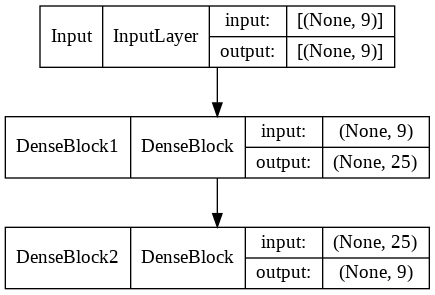

In [91]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [92]:
model = training(data_x, data_y, model, num_epochs, batch_size, [early_stopping])

Restoring model weights from the end of the best epoch: 480.
Epoch 00490: early stopping
Best accuracy - train: 0.9819004535675049, validation: 0.9909502267837524
Best loss - train: 0.0630735531449318, validation: 0.05070144310593605

Summary:
Avg accuracy - train: 0.9819004535675049, validation: 0.9909502267837524
Avg loss - train: 0.0630735531449318, validation: 0.05070144310593605


In [93]:
model.save(f"/content/model")

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


# TFLite

In [98]:
converter = tf.lite.TFLiteConverter.from_saved_model("/content/model")
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True

#Dynamic integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

#Full integer quantization
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
#converter.representative_dataset = representative_dataset

tflite_model = converter.convert()
target_file_dir = f"/content/tflite/"
target_file_path = f"{target_file_dir}model.tflite"

if not os.path.exists(target_file_dir):
    os.makedirs(target_file_dir)

# Save the tflite model
with open(target_file_path, 'wb') as f:
  f.write(tflite_model)
  print(f"Model saved successfully to {target_file_path}")

Model saved successfully to /content/tflite/model.tflite
